# Import Packages

In [4]:
# Default packages
import os
from os.path import join
from datetime import date, datetime, timedelta
from joblib import load, dump

# Set current directory to "src"
os.chdir(join(os.getcwd(), os.pardir, "src"))
print(f"Current working directory: {os.getcwd()}")

# Installed packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Defined modules
from util.util import *
from config.config import *
from process.dataloader import Data
from process.embed_gen import EmbedGen
from process.evaluate import *
from models import lstm_vae, cnn_vae
from models.lstm_ae import lstm_autoencoder
from models.lstm import basic_lstm
from visualize import plot

# Set TF log level to minimum
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Check GPU availability
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Current working directory: e:\Repositories\PCovNet\src
Found GPU at: /device:GPU:0


# Process Config

In [5]:
# Dictionaries of dataset paths
DATA_DIR_DICT = {
    'phase1': join(os.getcwd(), os.pardir, "data", "raw", "phase1"),
    'phase2': join(os.getcwd(), os.pardir, "data", "raw", "phase2")
}
INFO_DIR_DICT = {
    'covid_phase1': join(os.getcwd(), os.pardir, "data", "external", "covid_phase1_info.csv"),
    'covid_phase2': join(os.getcwd(), os.pardir, "data", "external", "covid_phase2_info.csv"),
    'healthy_phase1': join(os.getcwd(), os.pardir, "data", "external", "healthy_phase1_info.csv"),
    'non-covid_phase1': join(os.getcwd(), os.pardir, "data", "external", "non-covid_phase1_info.csv"),
}

# Import subject info
subject_info = pd.read_csv(
    INFO_DIR_DICT[f"{config['EXP_GROUP']}_{config['EXP_PHASE']}"])


# Assign experiment directory
config['EXP_DIR'] = join(os.getcwd(), os.pardir, "experiment",
                         config['EXP_NAME'])
# timestamp = datetime.now().strftime(f"%Y-%m-%d %H-%M__")
# config['EXP_DIR'] = join(os.getcwd(), os.pardir, "experiment",
#                          timestamp + config['EXP_NAME'])
handle_dir(config['EXP_DIR'])


# Add DATA_DIR
config['DATA_DIR'] = DATA_DIR_DICT[config['EXP_PHASE']]


# Export config
export_json(config, join(config['EXP_DIR'], "config.json"),
            print_json=True)

# Start logging
with open(join(config['EXP_DIR'], "log.txt"), 'w', encoding='utf-8') as f:
    for key, value in config.items():
        f.write(f"{key}: {value}\n")
    f.write("\n\n")


config
{
    "EXP_NAME": "phase2_covid_user_all_(48-8)_1000",
    "EXP_PHASE": "phase2",
    "EXP_GROUP": "covid",
    "EXP_TYPE": "individual",
    "AUGMENT": true,
    "LEN_WIN": 48,
    "N_WIN": 8,
    "LATENT_DIM": 6,
    "BATCH_SIZE": 64,
    "VAL_SPLIT": 0.05,
    "LEARNING_RATE": 0.0002,
    "EPOCH": 1000,
    "PATIENCE": 10,
    "EXP_DIR": "e:\\Repositories\\PCovNet\\src\\..\\experiment\\phase2_covid_user_all_(48-8)_1000",
    "DATA_DIR": "e:\\Repositories\\PCovNet\\src\\..\\data\\raw\\phase2"
}


# Import & Process Data

In [7]:
# Choose which data index from subject_info to run the experiment on
idx = 0

# Prepare data
data = Data(config=config, data_info=subject_info, index=idx)

# Log data properties
if data.error == True:
    print(data.error_message)
    with open(join(config['EXP_DIR'], "log.txt"), 'a', encoding='utf-8') as f:
        f.write(
            f"Index {idx}\t {data.id} {'-'*4} Data properties... ✘ ... {data.error_message}\n")
    # Use continue if run in a loop; otherwise raise error
    # continue
    raise ValueError("Data does not meet experiment criteria!")
else:
    print("Data properties... ✔\n")
    with open(join(config['EXP_DIR'], "log.txt"), 'a', encoding='utf-8') as f:
        f.write(f"Index {idx}\t {data.id} {'-'*4} Data properties... ✔\n")

# Print data info
data.print_info()

# Export dates
pd.DataFrame(data.date_dict, index=[0]).to_csv(
    join(config['EXP_DIR'], data.id + "_dates.csv"), index=False)


Data properties... ✔

            Subject Info
            Index:                0
            Phase:                phase2
            Group:                covid
            ID:                   P111019
            Device:               Fitbit
            
            Dataset Shape
            VAE Train:            (2199, 48, 1)
            VAE Train-aug:        (17592, 48, 1)
            VAE Test:             (1392, 48, 1)
            VAE Merged:           (3638, 48, 1)
            LSTM Train:           (1863, 8, 48, 1)
            LSTM Test:            (1056, 8, 48, 1)
            LSTM Merged:          (3302, 8, 48, 1)
        


# VAE Model

#### Assign and Compile VAE Model

In [8]:
# Get VAE model
vae_model = cnn_vae.VAE(n_timesteps=config['LEN_WIN'],
                        n_channels=data.train_dataset_vae.shape[-1],
                        latent_dim=config['LATENT_DIM'])
vae_model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(
                      learning_rate=config['LEARNING_RATE']),
                  metrics=[tf.metrics.MeanSquaredError()])

# Show VAE model summary
print("\nVAE Model Summary")
print("=================", end="\n\n")
vae_model.print_summary()



VAE Model Summary

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 48, 1)]      0           []                               
                                                                                                  
 encoder1 (Conv1D)              (None, 24, 128)      512         ['encoder_input[0][0]']          
                                                                                                  
 encoder2 (Conv1D)              (None, 12, 64)       24640       ['encoder1[0][0]']               
                                                                                                  
 encoder3 (Conv1D)              (None, 6, 32)        6176        ['encoder2[0][0]']               
                                                                        

#### Train VAE Model

In [9]:
# Assign checkpoint paths
vae_ckpt_path = join(
    config['EXP_DIR'], data.id + "_vae_checkpoint", "ckpt")

# Callbacks for VAE
early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        patience=config['PATIENCE'],
                                        mode='min',
                                        restore_best_weights=True)
checkpoint_callback = ModelCheckpoint(vae_ckpt_path,
                                      monitor='val_loss',
                                      verbose=0,
                                      mode='min',
                                      save_best_only=True,
                                      save_weights_only=True)

if not os.path.isfile(vae_ckpt_path + ".index"):
    # Train VAE
    vae_history = vae_model.fit(data.train_aug_dataset_vae,
                                validation_split=config['VAL_SPLIT'],
                                batch_size=config['BATCH_SIZE'],
                                epochs=config['EPOCH'],
                                shuffle=False,
                                verbose=1,
                                callbacks=[early_stopping_callback, checkpoint_callback])

    # Export model history
    export_history(vae_history, join(
        config['EXP_DIR'], data.id + "_vae_history.csv"))

    # Plot loss curve
    # print("\nVAE Loss Curve")
    # print("==============", end="\n")
    plot.loss_curve(vae_history, ref=data.id + "_VAE", save_plot=True,
                    close_plot=True)

else:
    vae_model.load_weights(vae_ckpt_path)
    print("VAE model weights loaded from:")
    print(vae_ckpt_path)


VAE model weights loaded from:
e:\Repositories\PCovNet\src\..\experiment\phase2_covid_user_all_(48-8)_1000\P111019_vae_checkpoint\ckpt


# Generate Embeddings

In [10]:
if not os.path.isfile(join(config['EXP_DIR'], f"{data.id}_embeddings.joblib")):
    # Get embedding dataset
    embed_gen = EmbedGen(config, vae_model,
                         data, verbose=True)

    # Save embed_gen object
    dump(embed_gen, join(config['EXP_DIR'],
                         f"{data.id}_embeddings.joblib"))
else:
    # Load embed_gen object
    embed_gen = load(join(config['EXP_DIR'], f"{data.id}_embeddings.joblib"))
    print("Embeddings loaded from:")
    print(join(config['EXP_DIR'], f"{data.id}_embeddings.joblib"))


Embeddings loaded from:
e:\Repositories\PCovNet\src\..\experiment\phase2_covid_user_all_(48-8)_1000\P111019_embeddings.joblib


# LSTM Model for Embeddings

#### Assign and Compile LSTM Model

In [11]:
# Get LSTM MODEL
lstm_model = lstm_autoencoder(n_timesteps=config['N_WIN'] - 1,
                              n_features=config['LATENT_DIM'])
lstm_model.compile(loss=tf.losses.MeanSquaredError(),
                   optimizer=tf.optimizers.Adam(
                       learning_rate=config['LEARNING_RATE']),
                   metrics=['mse'])

# Show LSTM model summary
print("\nLSTM Model Summary")
print("==================", end="\n\n")
lstm_model.summary()



LSTM Model Summary

Model: "LSTM_Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 6)]            0         
                                                                 
 encoder1 (LSTM)             (None, 7, 128)            69120     
                                                                 
 encoder2 (LSTM)             (None, 64)                49408     
                                                                 
 repeat_vec (RepeatVector)   (None, 7, 64)             0         
                                                                 
 decoder1 (LSTM)             (None, 7, 64)             33024     
                                                                 
 decoder2 (LSTM)             (None, 7, 128)            98816     
                                                                 
 reconst (TimeDistributed)   

#### Train LSTM Model

In [12]:
# Assign checkpoint paths
lstm_ckpt_path = join(
    config['EXP_DIR'], data.id + "_lstm_checkpoint", "ckpt")
    
# Callbacks for LSTM
early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        patience=config['PATIENCE'],
                                        mode='min',
                                        restore_best_weights=True)
checkpoint_callback = ModelCheckpoint(lstm_ckpt_path,
                                      monitor='val_loss',
                                      verbose=0,
                                      mode='min',
                                      save_best_only=True,
                                      save_weights_only=True)

if not os.path.isfile(lstm_ckpt_path + ".index"):
    # Train LSTM
    lstm_history = lstm_model.fit(embed_gen.x_train, embed_gen.y_train,
                                  validation_data=(
                                      embed_gen.x_test, embed_gen.y_test),
                                  batch_size=config['BATCH_SIZE'],
                                  epochs=config['EPOCH'],
                                  callbacks=[
                                      early_stopping_callback, checkpoint_callback],
                                  verbose=1)

    # Export model history
    export_history(lstm_history, join(
        config['EXP_DIR'], data.id + "_lstm_history.csv"))

    # Plot loss curve
    # print("\nLSTM Loss Curve")
    # print("===============", end="\n")
    plot.loss_curve(lstm_history, ref=data.id + "_LSTM", save_plot=True,
                    close_plot=True)
else:
    lstm_model.load_weights(lstm_ckpt_path)
    print("LSTM model weights loaded from:")
    print(lstm_ckpt_path)


LSTM model weights loaded from:
e:\Repositories\PCovNet\src\..\experiment\phase2_covid_user_all_(48-8)_1000\P111019_lstm_checkpoint\ckpt


# Evaluate VAE Model

#### Calculate Loss for VAE Model

In [13]:
# Calculate vae losses
print("\n")
print("Calculate vae train loss... ", end="")
train_loss = vae_model.get_loss_array(data.train_dataset_vae)
print("✓")
print("Calculate vae test loss... ", end="")
test_loss = vae_model.get_loss_array(data.test_dataset_vae)
print("✓")
print("Calculate vae all loss... ", end="")
seq_loss = vae_model.get_loss_array(data.merged_dataset_vae)
print("✓")
print("\n")




Calculate vae train loss... ✓
Calculate vae test loss... ✓
Calculate vae all loss... ✓




#### Evaluate Results for VAE Model

Loss Distribution Plot


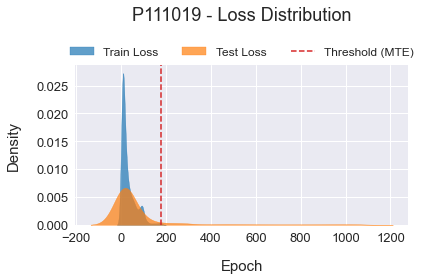


Metrics


{'threshold': 'MTE',
 'Detection': 'Late',
 'Total': 3638,
 'TP': 128,
 'FP': 49,
 'FN': 500,
 'TN': 2961,
 'Sensitivity': 0.20382165605095542,
 'Specificity': 0.9837209302325581,
 'PPV': 0.7231638418079096,
 'NPV': 0.8555330829240104,
 'Precision': 0.7231638418079096,
 'Recall': 0.20382165605095542,
 'Fbeta': 0.7053688345700566,
 'F1': 0.31801242236024846}


RHR Plot


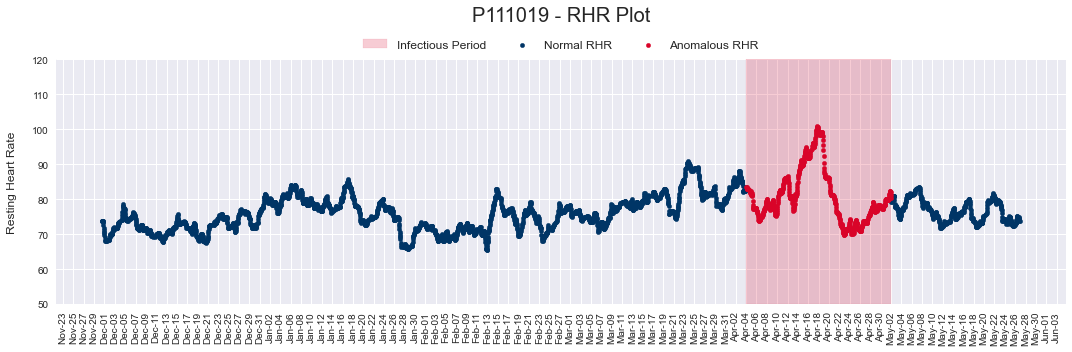


Anomaly Plot


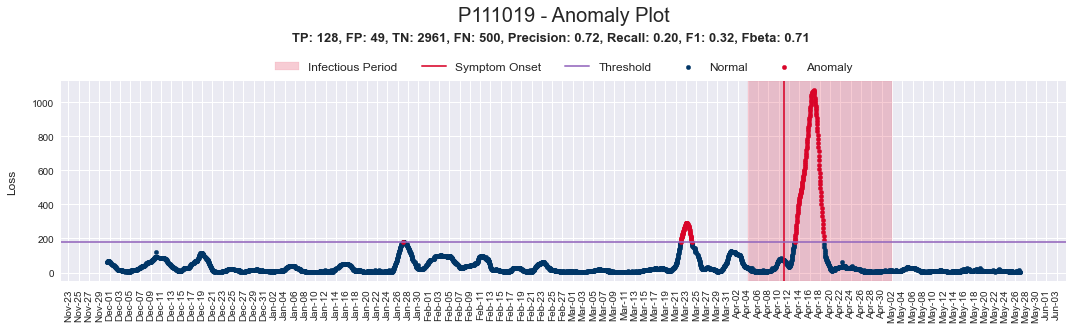

In [ ]:
threshold_dict = {
    'MTE': train_loss.max(),
    # 'STE': train_loss.mean() + (3 * train_loss.std())
}

print("\nLoss Distribution Plot")
print("======================", end="\n")
plot.loss_dist(train_loss, test_loss, threshold_dict, ref=f"{data.id}_VAE",
               save_plot=True, close_plot=True)

metrics, loss_df_dict = evaluate_model(config, data, train_loss, test_loss,
                                       seq_loss, threshold_dict, ref=f"{data.id}_VAE")
print("\nMetrics")
print("=======", end="\n")
print(metrics)

print("\nRHR Plot")
print("========", end="\n")
# Plot RHR wrt infectious period
plot.rhr_plot(loss_df_dict['all'], data.date_dict, title=f"{data.id} - RHR Plot",
              ref=f"{data.id}_VAE", save_plot=True, close_plot=True)

print("\nAnomaly Plot")
print("=============", end="\n")
# Plot anomalies
plot.anomaly_plot(loss_df_dict['all'], data.date_dict, threshold_dict['MTE'],
                  metrics, title=f"{data.id} - Anomaly Plot", ref=f"{data.id}_VAE",
                  save_plot=True, close_plot=True)


# Evaluate LSTM Model

#### Calculate Loss for LSTM Model

In [ ]:
# Calculate vae-lstm losses
print("\n")
print("Calculate lstm train loss... ", end="")
train_loss = get_vae_lstm_loss(data.train_dataset_lstm,
                               vae_model, lstm_model)
print("Calculate lstm test loss... ", end="")
test_loss = get_vae_lstm_loss(data.test_dataset_lstm,
                              vae_model, lstm_model)
print("Calculate lstm all loss... ", end="")
seq_loss = get_vae_lstm_loss(data.merged_dataset_lstm,
                             vae_model, lstm_model)
print("\n")


#### Evaluate Results for VAE Model

Loss Distribution Plot


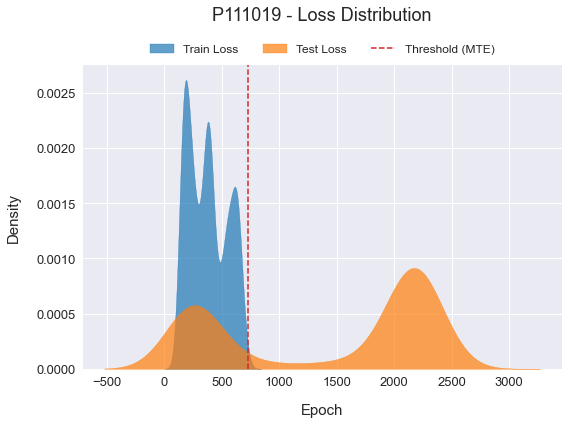


Metrics


{'threshold': 'MTE',
 'Detection': 'Late',
 'Total': 3110,
 'TP': 280,
 'FP': 402,
 'FN': 316,
 'TN': 2112,
 'Sensitivity': 0.4697986577181208,
 'Specificity': 0.8400954653937948,
 'PPV': 0.41055718475073316,
 'NPV': 0.8698517298187809,
 'Precision': 0.41055718475073316,
 'Recall': 0.4697986577181208,
 'Fbeta': 0.4110704110704111,
 'F1': 0.4381846635367762}


RHR Plot


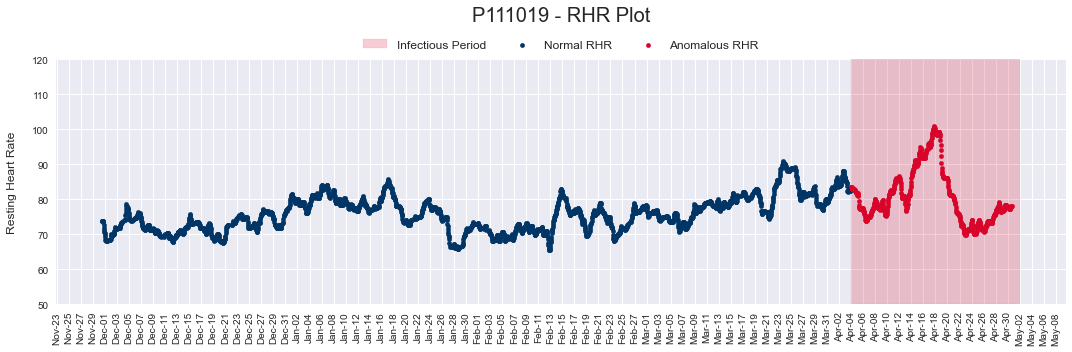


Anomaly Plot


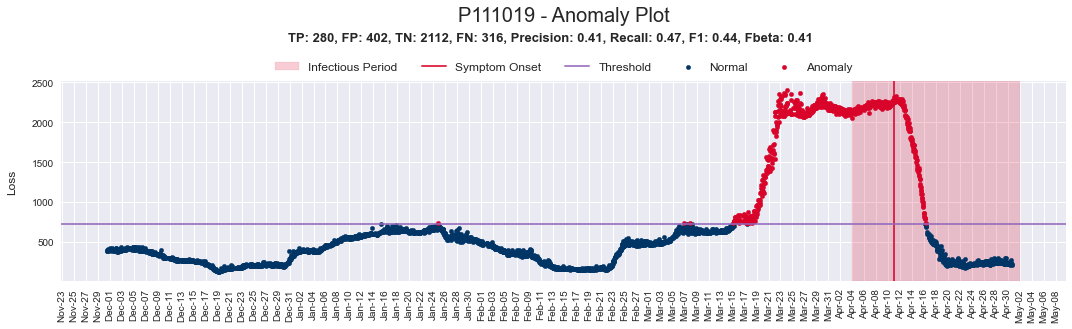

In [ ]:
threshold_dict = {
    'MTE': train_loss.max(),
    # 'STE': train_loss.mean() + (3 * train_loss.std())
}

print("\nLoss Distribution Plot")
print("======================", end="\n")
plot.loss_dist(train_loss, test_loss, threshold_dict, ref=f"{data.id}_LSTM",
               save_plot=True, close_plot=True)

metrics, loss_df_dict = evaluate_model(config, data, train_loss, test_loss,
                                       seq_loss, threshold_dict, ref=f"{data.id}_LSTM")
print("\nMetrics")
print("=======", end="\n")
print(metrics)

print("\nRHR Plot")
print("========", end="\n")
# Plot RHR wrt infectious period
plot.rhr_plot(loss_df_dict['all'], data.date_dict, title=f"{data.id} - RHR Plot",
              ref=f"{data.id}_LSTM", save_plot=True, close_plot=True)

print("\nAnomaly Plot")
print("=============", end="\n")
# Plot anomalies
plot.anomaly_plot(loss_df_dict['all'], data.date_dict, threshold_dict['MTE'],
                  metrics, title=f"{data.id} - Anomaly Plot", ref=f"{data.id}_LSTM",
                  save_plot=True, close_plot=True)
